# Klasifikasi Koin Rupiah (8 Classes - Split by Side) dengan CNN

Mengklasifikasikan koin rupiah berdasarkan nominal DAN sisi koin (angka/gambar):
- Rp 100 Angka, Rp 100 Gambar
- Rp 200 Angka, Rp 200 Gambar  
- Rp 500 Angka, Rp 500 Gambar
- Rp 1000 Angka, Rp 1000 Gambar

Menggunakan Edge Detection + **Convolutional Neural Network (CNN)** dengan dataset yang sudah di-split per sisi koin.

**Dokumentasi lengkap**: Lihat [COIN-README.md](./COIN-README.md)

## 1. Import Libraries

In [1]:
import sys
import os
from pathlib import Path

# Add src to path
sys.path.append(str(Path('../src').resolve()))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras for CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


## 2. Setup Paths dan Konfigurasi

Dataset: `dataset_splitted` dengan 8 kelas (4 nominal × 2 sisi).  
Image size 256×256, cropped to circle diameter untuk normalisasi skala.

In [2]:
# Directories
BASE_DIR = Path('..').resolve()
DATASET_DIR = BASE_DIR / 'dataset_splitted'  # Using splitted dataset (8 classes)
RESULTS_DIR = BASE_DIR / 'results' / 'coin_classification_cnn'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
(RESULTS_DIR / 'confusion_matrix').mkdir(exist_ok=True)
(RESULTS_DIR / 'visualizations').mkdir(exist_ok=True)

# Configuration
IMAGE_SIZE = (256, 256)  # CNN input size
MAX_IMAGES_PER_CLASS = None  # Set to None for unlimited
RANDOM_SEED = 42
TEST_SIZE = 0.2
EPOCHS = 5
BATCH_SIZE = 32

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(f"Dataset: {DATASET_DIR}")
print(f"Config: {IMAGE_SIZE}, max {MAX_IMAGES_PER_CLASS or 'unlimited'} imgs/class, test {TEST_SIZE*100}%")
print(f"CNN: {EPOCHS} epochs, batch size {BATCH_SIZE}")

Dataset: D:\dev\semester5\pengolahan-citra\projek-edge-detection\dataset_splitted
Config: (256, 256), max unlimited imgs/class, test 20.0%
CNN: 5 epochs, batch size 32


## 3. Fungsi Preprocessing Koin

In [3]:
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    to normalize lighting variations across images.
    """
    if len(image.shape) == 3:
        # For color images, convert to LAB and apply CLAHE on L channel
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        l_clahe = clahe.apply(l)
        lab_clahe = cv2.merge([l_clahe, a, b])
        result = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
    else:
        # For grayscale images, apply CLAHE directly
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        result = clahe.apply(image)
    return result


def apply_canny_edge(image, use_clahe=True):
    """Apply Canny edge detection with optional CLAHE normalization"""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Apply CLAHE to normalize lighting before edge detection
    if use_clahe:
        gray = apply_clahe(gray)
    
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    return edges


def apply_sobel_edge(image, use_clahe=True):
    """Apply Sobel edge detection with optional CLAHE normalization"""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Apply CLAHE to normalize lighting before edge detection
    if use_clahe:
        gray = apply_clahe(gray)
    
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel_combined = np.uint8(sobel_combined / sobel_combined.max() * 255)
    return sobel_combined


def detect_and_segment_coin(image, edge_method='canny', use_clahe=True):
    """Detect coin using Hough Circle Transform and segment it"""
    if edge_method == 'canny':
        edges = apply_canny_edge(image, use_clahe=use_clahe)
    else:
        edges = apply_sobel_edge(image, use_clahe=use_clahe)
    
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    gray_blurred = cv2.GaussianBlur(gray, (9, 9), 2)
    
    circles = cv2.HoughCircles(
        gray_blurred,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=50,
        param1=100,
        param2=30,
        minRadius=20,
        maxRadius=200
    )
    
    segmented = image.copy()
    circle_info = None
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        circle = circles[0, 0]
        x, y, radius = circle[0], circle[1], circle[2]
        circle_info = (x, y, radius)
        
        mask = np.zeros(gray.shape, dtype=np.uint8)
        cv2.circle(mask, (x, y), radius, 255, -1)
        
        if len(image.shape) == 3:
            segmented = cv2.bitwise_and(image, image, mask=mask)
        else:
            segmented = cv2.bitwise_and(image, image, mask=mask)
    
    return segmented, circle_info, edges

## 5. Fungsi Data Augmentation

In [4]:
def augment_image(image):
    """Apply augmentation: rotation, flip, brightness (8x total)"""
    augmented = [image]
    
    for angle in [90, 180, 270]:
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h))
        augmented.append(rotated)
    
    flipped_h = cv2.flip(image, 1)
    flipped_v = cv2.flip(image, 0)
    augmented.extend([flipped_h, flipped_v])
    
    bright = cv2.convertScaleAbs(image, alpha=1.2, beta=20)
    dark = cv2.convertScaleAbs(image, alpha=0.8, beta=-20)
    augmented.extend([bright, dark])
    
    return augmented

## 6. Load dan Eksplorasi Dataset

In [5]:
# Build class names from nested folder structure: "Koin Rp XXX/angka" and "Koin Rp XXX/gambar"
class_names = []
coin_types = sorted([d.name for d in DATASET_DIR.iterdir() if d.is_dir()])

for coin_type in coin_types:
    coin_dir = DATASET_DIR / coin_type
    sides = sorted([s.name for s in coin_dir.iterdir() if s.is_dir()])
    for side in sides:
        class_name = f"{coin_type} - {side}"
        class_names.append(class_name)

print(f"Total Classes: {len(class_names)}")
print(f"Classes: {class_names}\n")

# Count images per class
total_images = 0
for cls_name in class_names:
    # Parse class name back to path: "Koin Rp 100 - angka" -> "Koin Rp 100/angka"
    parts = cls_name.rsplit(' - ', 1)
    coin_type, side = parts[0], parts[1]
    cls_dir = DATASET_DIR / coin_type / side
    images = list(cls_dir.glob('*.jpg')) + list(cls_dir.glob('*.png')) + list(cls_dir.glob('*.jpeg')) + list(cls_dir.glob('*.JPG'))
    print(f"{cls_name}: {len(images)} images")
    total_images += len(images)

print(f"\nTotal images: {total_images}")

Total Classes: 8
Classes: ['Koin Rp 100 - angka', 'Koin Rp 100 - gambar', 'Koin Rp 1000 - angka', 'Koin Rp 1000 - gambar', 'Koin Rp 200 - angka', 'Koin Rp 200 - gambar', 'Koin Rp 500 - angka', 'Koin Rp 500 - gambar']

Koin Rp 100 - angka: 140 images
Koin Rp 100 - gambar: 116 images
Koin Rp 1000 - angka: 268 images
Koin Rp 1000 - gambar: 112 images
Koin Rp 200 - angka: 132 images
Koin Rp 200 - gambar: 138 images
Koin Rp 500 - angka: 236 images
Koin Rp 500 - gambar: 118 images

Total images: 1260


## 7. Visualisasi Sample Dataset

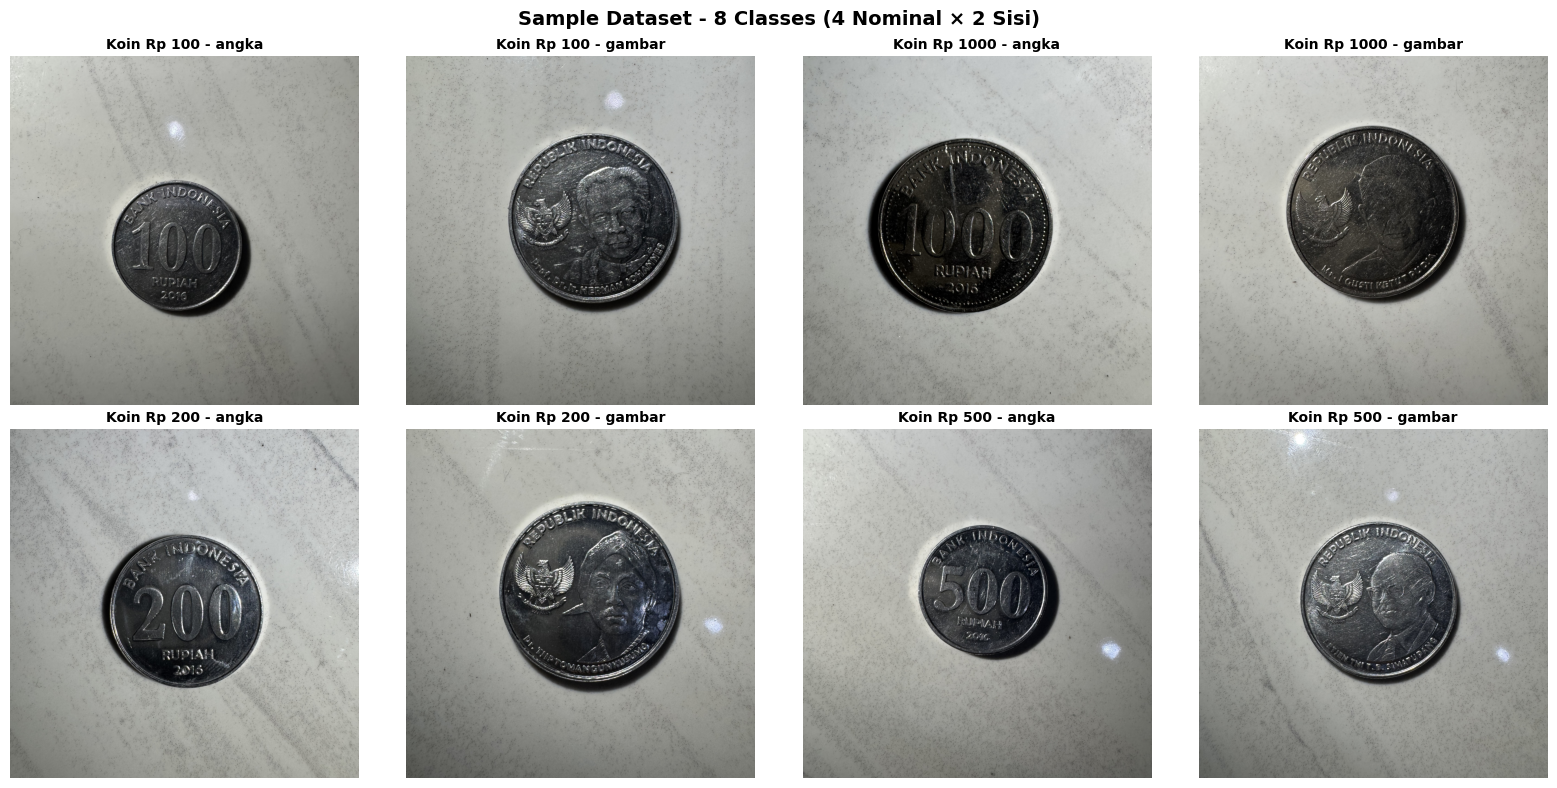

In [6]:
# Visualize 1 sample per class (8 classes = 2 rows x 4 cols)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, cls_name in enumerate(class_names):
    # Parse class name to path
    parts = cls_name.rsplit(' - ', 1)
    coin_type, side = parts[0], parts[1]
    cls_dir = DATASET_DIR / coin_type / side
    images = list(cls_dir.glob('*.jpg')) + list(cls_dir.glob('*.png')) + list(cls_dir.glob('*.jpeg')) + list(cls_dir.glob('*.JPG'))
    
    if images:
        img_path = images[0]
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(cls_name, fontsize=10, fontweight='bold')
        axes[idx].axis('off')

plt.suptitle('Sample Dataset - 8 Classes (4 Nominal × 2 Sisi)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'visualizations' / 'dataset_samples.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Visualisasi Pipeline Preprocessing

Menampilkan: Original → CLAHE → Sobel Edge → Hough Circle → Cropped (final input for feature extraction)

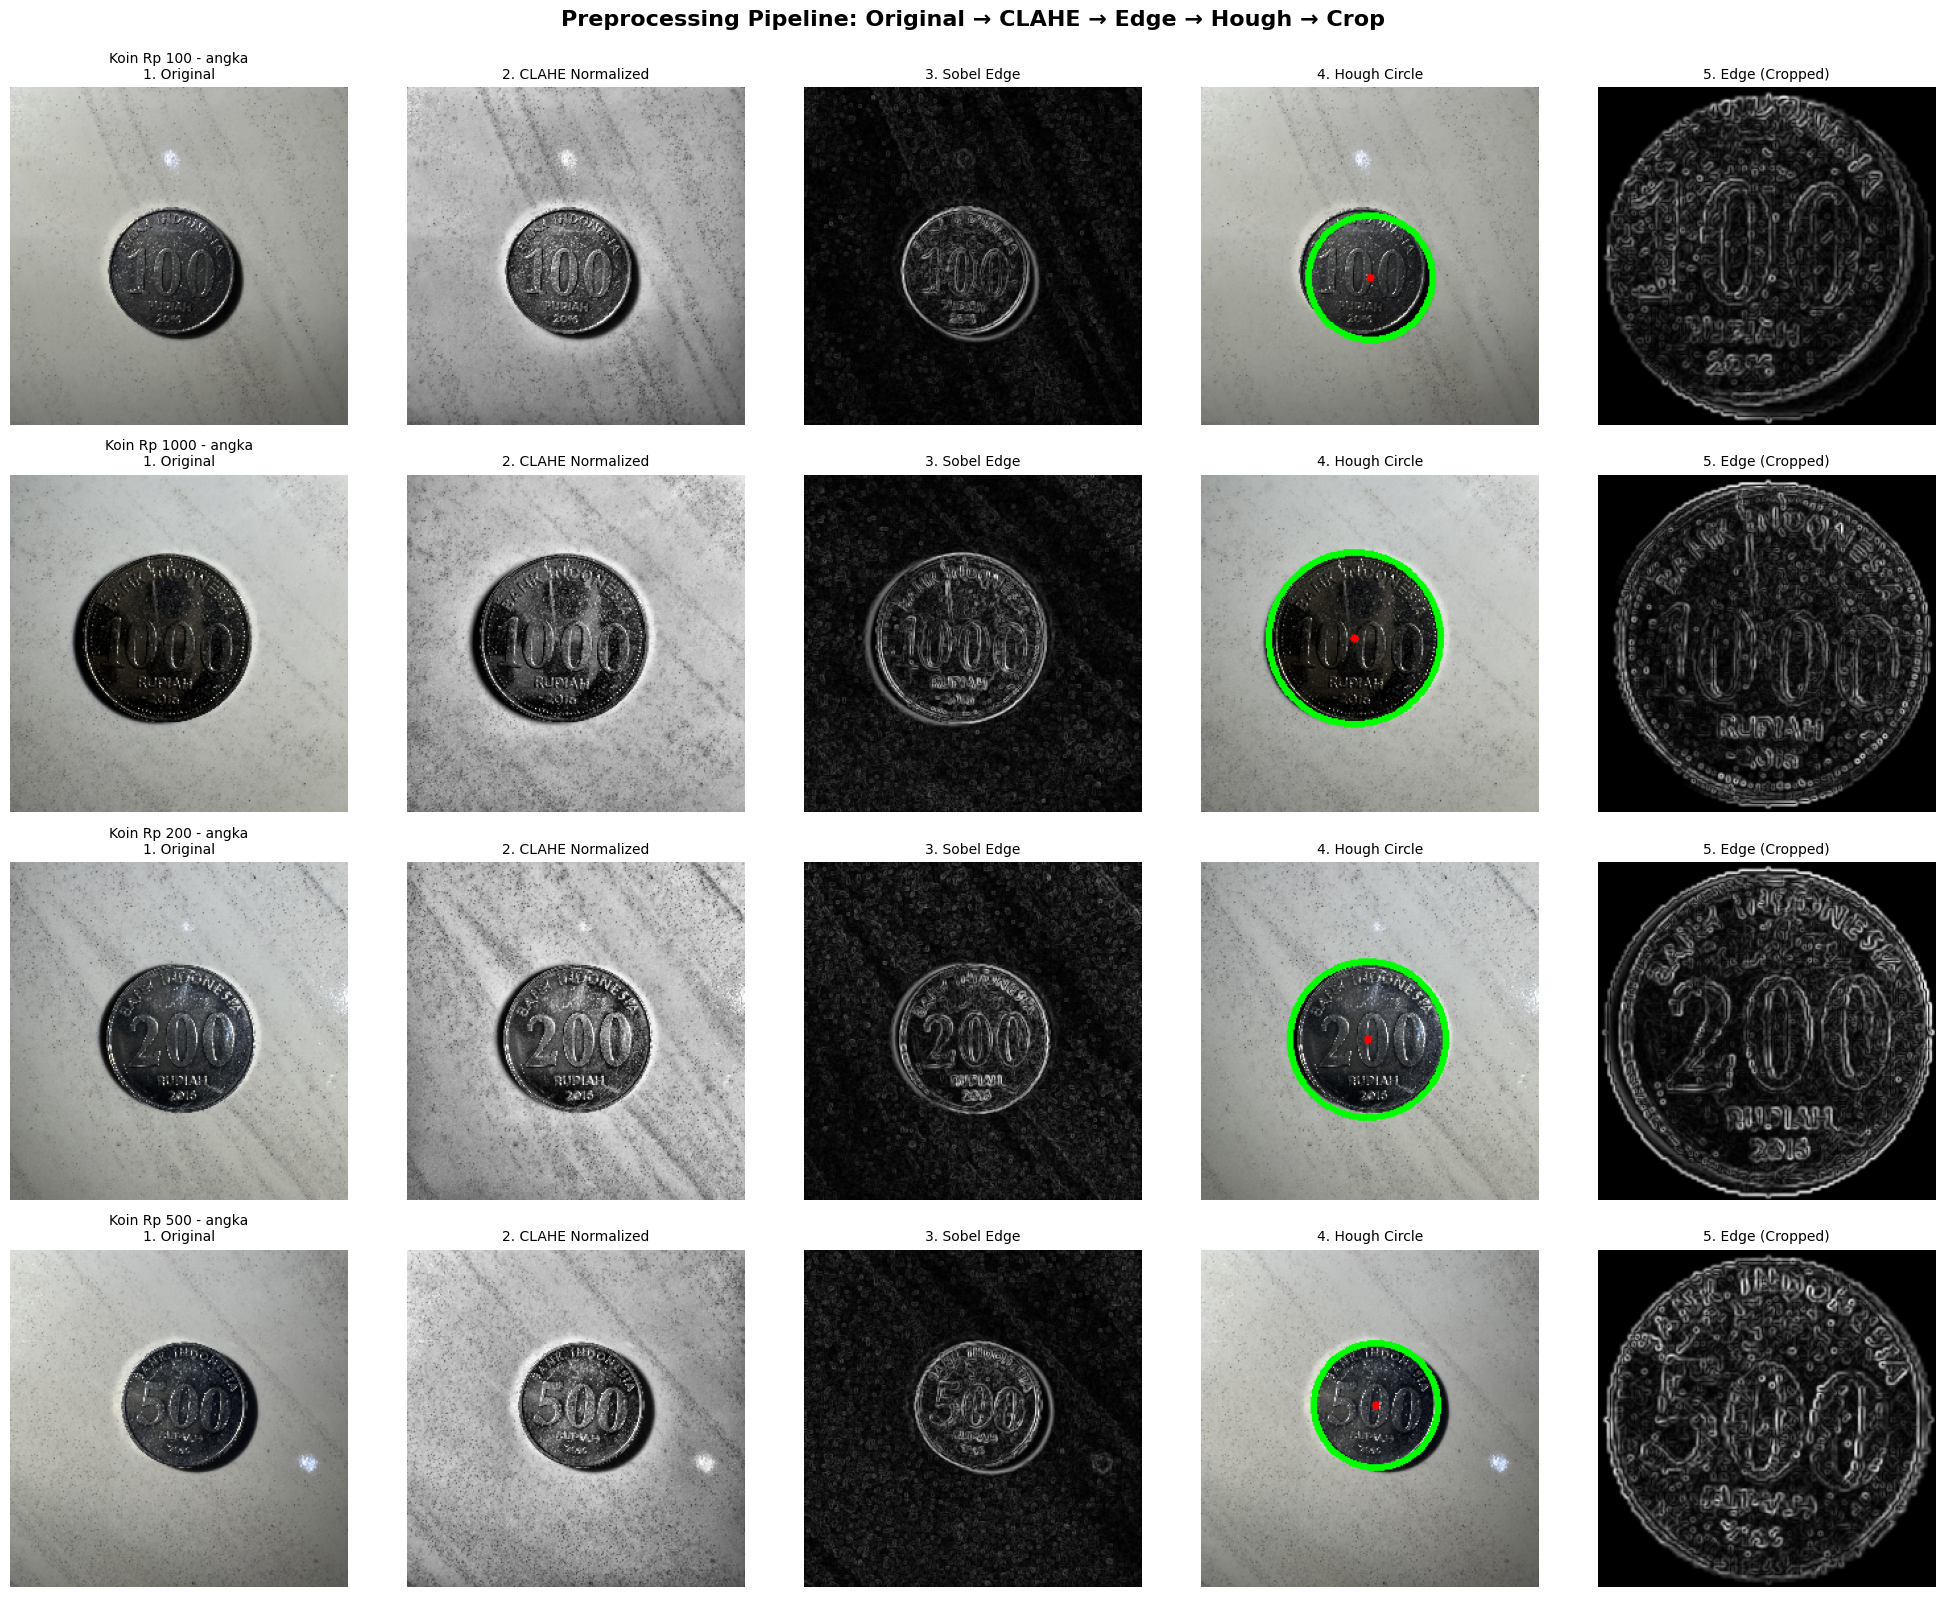


Pipeline Summary:
1. Original: Load and resize to 256x256
2. CLAHE: Normalize lighting variations
3. Sobel Edge: Detect edges on normalized image
4. Hough Circle: Detect coin boundary
5. Cropped: Crop to circle bounding box, resize to 256x256 (scale normalization)


In [7]:
# Import crop function
import sys
sys.path.insert(0, str(Path('..').resolve()))
from preprocessing import crop_coin_to_circle

# Visualize preprocessing pipeline for a subset of classes (4 samples to keep it readable)
sample_classes = class_names[::2]  # Every other class

fig, axes = plt.subplots(len(sample_classes), 5, figsize=(20, len(sample_classes) * 4))

for idx, cls_name in enumerate(sample_classes):
    # Parse class name to path
    parts = cls_name.rsplit(' - ', 1)
    coin_type, side = parts[0], parts[1]
    cls_dir = DATASET_DIR / coin_type / side
    images = list(cls_dir.glob('*.jpg')) + list(cls_dir.glob('*.png')) + list(cls_dir.glob('*.jpeg')) + list(cls_dir.glob('*.JPG'))
    
    if images:
        img_path = images[0]
        img = cv2.imread(str(img_path))
        img_resized = cv2.resize(img, IMAGE_SIZE)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        
        # Show CLAHE normalization effect
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        gray_clahe = apply_clahe(gray)
        
        # Apply Sobel edge detection with CLAHE
        segmented, circle_info, edges = detect_and_segment_coin(img_resized, edge_method='sobel', use_clahe=True)
        
        # Draw circle on original for visualization
        img_with_circle = img_resized.copy()
        if circle_info:
            x, y, r = circle_info
            cv2.circle(img_with_circle, (x, y), r, (0, 255, 0), 3)
            cv2.circle(img_with_circle, (x, y), 3, (0, 0, 255), -1)
        
        # Crop to circle diameter
        cropped = crop_coin_to_circle(segmented, circle_info, IMAGE_SIZE)
        
        # Apply edge detection to cropped version (with CLAHE)
        edges_cropped = apply_sobel_edge(cropped, use_clahe=True)
        
        # Plot pipeline
        axes[idx, 0].imshow(img_rgb)
        axes[idx, 0].set_title(f'{cls_name}\n1. Original', fontsize=10)
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(gray_clahe, cmap='gray')
        axes[idx, 1].set_title('2. CLAHE Normalized', fontsize=10)
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(edges, cmap='gray')
        axes[idx, 2].set_title('3. Sobel Edge', fontsize=10)
        axes[idx, 2].axis('off')
        
        axes[idx, 3].imshow(cv2.cvtColor(img_with_circle, cv2.COLOR_BGR2RGB))
        axes[idx, 3].set_title('4. Hough Circle', fontsize=10)
        axes[idx, 3].axis('off')
        
        axes[idx, 4].imshow(edges_cropped, cmap='gray')
        axes[idx, 4].set_title('5. Edge (Cropped)', fontsize=10)
        axes[idx, 4].axis('off')

plt.suptitle('Preprocessing Pipeline: Original → CLAHE → Edge → Hough → Crop', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'visualizations' / 'preprocessing_pipeline.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPipeline Summary:")
print(f"1. Original: Load and resize to {IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}")
print("2. CLAHE: Normalize lighting variations")
print("3. Sobel Edge: Detect edges on normalized image")
print("4. Hough Circle: Detect coin boundary")
print(f"5. Cropped: Crop to circle bounding box, resize to {IMAGE_SIZE[0]}x{IMAGE_SIZE[1]} (scale normalization)")

## 9. Load dan Preprocess Images untuk CNN

In [8]:
def load_images_for_cnn(dataset_dir, class_names, edge_method='sobel', apply_augmentation=False, max_images=None):
    """
    Load images and preprocess for CNN (using edge-detected cropped images)
    
    Supports nested folder structure: dataset_dir/CoinType/Side/images
    
    Args:
        dataset_dir: Path to dataset directory
        class_names: List of class names in format "Koin Rp XXX - side"
        edge_method: 'canny' or 'sobel'
        apply_augmentation: Whether to apply data augmentation
        max_images: Maximum images per class (None = no limit)
    
    Returns:
        X: Image array (normalized 0-1)
        y: Labels
    """
    import sys
    sys.path.insert(0, str(Path('..').resolve()))
    from preprocessing import crop_coin_to_circle
    
    X = []
    y = []
    
    for label, cls_name in enumerate(class_names):
        # Parse class name to path: "Koin Rp 100 - angka" -> "Koin Rp 100/angka"
        parts = cls_name.rsplit(' - ', 1)
        coin_type, side = parts[0], parts[1]
        cls_dir = dataset_dir / coin_type / side
        
        images = list(cls_dir.glob('*.jpg')) + list(cls_dir.glob('*.png')) + list(cls_dir.glob('*.jpeg')) + list(cls_dir.glob('*.JPG'))
        
        # Limit images per class if specified
        if max_images is not None and len(images) > max_images:
            np.random.shuffle(images)
            images = images[:max_images]
        
        print(f"Processing {cls_name}: {len(images)} images", end='')
        
        success_count = 0
        for img_path in images:
            # Load and resize
            img = cv2.imread(str(img_path))
            if img is None:
                continue
            
            img_resized = cv2.resize(img, IMAGE_SIZE)
            
            # Apply augmentation if enabled
            if apply_augmentation:
                augmented_images = augment_image(img_resized)
            else:
                augmented_images = [img_resized]
            
            # Process each augmented image
            for aug_img in augmented_images:
                # 1. Detect circle on original image
                segmented_original, circle_info, _ = detect_and_segment_coin(aug_img, edge_method)
                
                # Only add if circle detected (for better quality)
                if circle_info is not None:
                    # 2. Crop to circle diameter and resize (NORMALIZES SCALE)
                    cropped = crop_coin_to_circle(segmented_original, circle_info, IMAGE_SIZE)
                    
                    # 3. Apply edge detection to cropped version
                    if edge_method == 'canny':
                        edges_cropped = apply_canny_edge(cropped)
                    else:
                        edges_cropped = apply_sobel_edge(cropped)
                    
                    # 4. Normalize to 0-1 range for CNN
                    edges_normalized = edges_cropped.astype(np.float32) / 255.0
                    
                    # 5. Add channel dimension (H, W) -> (H, W, 1)
                    edges_normalized = np.expand_dims(edges_normalized, axis=-1)
                    
                    X.append(edges_normalized)
                    y.append(label)
                    success_count += 1
        
        aug_text = " (with augmentation)" if apply_augmentation else ""
        print(f" -> {success_count} samples{aug_text}")
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y

### 9.1 Load Images dengan Sobel Edge Detection

Using cropped version only: coin is cropped to circle diameter and resized to 256×256 for CNN input.

In [9]:
print("="*70)
print("SOBEL EDGE DETECTION + CROPPING + AUGMENTATION (8 CLASSES)")
print("="*70)

# Load images with Sobel edge detection and augmentation
X_sobel, y_sobel = load_images_for_cnn(
    DATASET_DIR, 
    class_names, 
    edge_method='sobel',
    apply_augmentation=True,
    max_images=MAX_IMAGES_PER_CLASS
)

print(f"\nTotal samples (Sobel): {len(X_sobel)}")
print(f"Image shape: {X_sobel.shape[1:]}")
print(f"Classes: {len(class_names)}")

# Check balance
unique, counts = np.unique(y_sobel, return_counts=True)
print("\nDistribusi data per kelas:")
for cls_idx, count in zip(unique, counts):
    print(f"  {class_names[cls_idx]}: {count} samples")

SOBEL EDGE DETECTION + CROPPING + AUGMENTATION (8 CLASSES)
Processing Koin Rp 100 - angka: 140 images -> 1056 samples (with augmentation)
Processing Koin Rp 100 - gambar: 116 images -> 1056 samples (with augmentation)
Processing Koin Rp 100 - gambar: 116 images -> 896 samples (with augmentation)
Processing Koin Rp 1000 - angka: 268 images -> 896 samples (with augmentation)
Processing Koin Rp 1000 - angka: 268 images -> 2078 samples (with augmentation)
Processing Koin Rp 1000 - gambar: 112 images -> 2078 samples (with augmentation)
Processing Koin Rp 1000 - gambar: 112 images -> 864 samples (with augmentation)
Processing Koin Rp 200 - angka: 132 images -> 864 samples (with augmentation)
Processing Koin Rp 200 - angka: 132 images -> 1038 samples (with augmentation)
Processing Koin Rp 200 - gambar: 138 images -> 1038 samples (with augmentation)
Processing Koin Rp 200 - gambar: 138 images -> 1102 samples (with augmentation)
Processing Koin Rp 500 - angka: 236 images -> 1102 samples (with a

## 10. Split Data Training dan Testing

In [10]:
# Split data for CNN
X_train, X_test, y_train, y_test = train_test_split(
    X_sobel, y_sobel, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y_sobel
)

# Convert labels to one-hot encoding for CNN
y_train_onehot = to_categorical(y_train, num_classes=len(class_names))
y_test_onehot = to_categorical(y_test, num_classes=len(class_names))

print("Data Split for CNN:")
print(f"  Training set: {X_train.shape[0]} samples, shape: {X_train.shape}")
print(f"  Testing set: {X_test.shape[0]} samples, shape: {X_test.shape}")
print(f"  Labels (one-hot): {y_train_onehot.shape[1]} classes")

Data Split for CNN:
  Training set: 7888 samples, shape: (7888, 256, 256, 1)
  Testing set: 1972 samples, shape: (1972, 256, 256, 1)
  Labels (one-hot): 8 classes


## 11. Build CNN Model

Membangun arsitektur Convolutional Neural Network untuk klasifikasi koin.

In [11]:
def build_cnn_model(input_shape, num_classes):
    """
    Build CNN model for coin classification
    
    Args:
        input_shape: Tuple (height, width, channels)
        num_classes: Number of output classes
    
    Returns:
        Compiled Keras model
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build the model
input_shape = X_train.shape[1:]  # (256, 256, 1)
num_classes = len(class_names)

model = build_cnn_model(input_shape, num_classes)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 34,275,816 (130.75 MB)

 Trainable params: 34,272,872 (130.74 MB)

 Non-trainable params: 2,944 (11.50 KB)

## 12. Train CNN Model

In [12]:
# Callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

print("="*70)
print("TRAINING CNN MODEL")
print("="*70)
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_test)}")
print("="*70)

# Train the model
history = model.fit(
    X_train, y_train_onehot,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test_onehot),
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*70)
print("TRAINING COMPLETED!")
print("="*70)

TRAINING CNN MODEL
Epochs: 5
Batch size: 32
Training samples: 7888
Validation samples: 1972
Epoch 1/5
Epoch 1/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.7135 - loss: 0.9007 - val_accuracy: 0.0953 - val_loss: 12.9064 - learning_rate: 0.0010
Epoch 2/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.7135 - loss: 0.9007 - val_accuracy: 0.0953 - val_loss: 12.9064 - learning_rate: 0.0010
Epoch 2/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.8930 - loss: 0.3147 - val_accuracy: 0.1998 - val_loss: 7.2155 - learning_rate: 0.0010
Epoch 3/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.8930 - loss: 0.3147 - val_accuracy: 0.1998 - val_loss: 7.2155 - learning_rate: 0.0010
Epoch 3/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.9359 - loss: 0.1854 - val_accuracy: 0.7394 - val_loss: 0.8952 - learning_rate: 0.0010
Epoch 4/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.9359 - loss: 0.1854 - val_accuracy: 0.7394 - val_loss: 0.8952 - learni

## 13. Visualisasi Training History

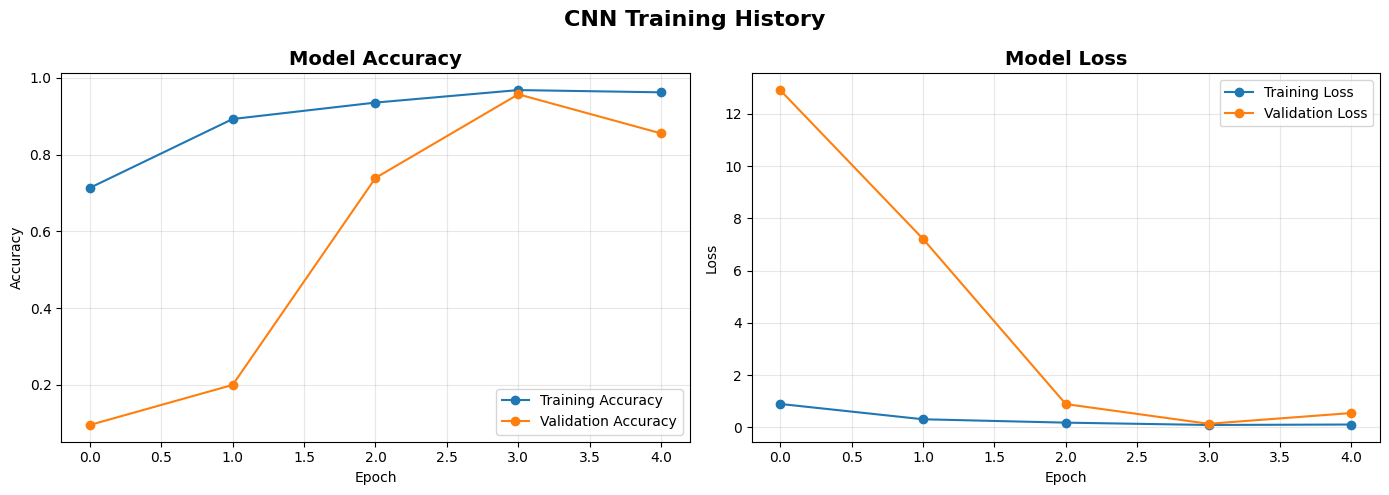


Final Training Accuracy: 0.9626
Final Validation Accuracy: 0.8555


In [13]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='o')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.suptitle('CNN Training History', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'visualizations' / 'training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

## 14. Evaluate CNN Model

In [14]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot, verbose=0)

# Get predictions
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

print("="*80)
print("CNN MODEL EVALUATION RESULTS")
print("="*80)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("="*80)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Save results
results_df = pd.DataFrame({
    'Model': ['CNN (Sobel Edge)'],
    'Edge Detection': ['Sobel'],
    'Image Size': [f'{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}'],
    'Epochs': [EPOCHS],
    'Accuracy': [test_accuracy]
})
results_df.to_csv(RESULTS_DIR / 'model_comparison.csv', index=False)
print(f"\nResults saved to: {RESULTS_DIR / 'model_comparison.csv'}")

CNN MODEL EVALUATION RESULTS
Test Loss: 0.1423
Test Accuracy: 0.9574 (95.74%)

Classification Report:
                       precision    recall  f1-score   support

  Koin Rp 100 - angka       0.95      0.97      0.96       211
 Koin Rp 100 - gambar       1.00      0.70      0.83       179
 Koin Rp 1000 - angka       0.99      0.97      0.98       416
Koin Rp 1000 - gambar       0.82      0.98      0.89       173
  Koin Rp 200 - angka       0.99      0.99      0.99       208
 Koin Rp 200 - gambar       1.00      0.99      0.99       220
  Koin Rp 500 - angka       0.95      1.00      0.97       377
 Koin Rp 500 - gambar       0.96      0.98      0.97       188

             accuracy                           0.96      1972
            macro avg       0.96      0.95      0.95      1972
         weighted avg       0.96      0.96      0.96      1972


Results saved to: D:\dev\semester5\pengolahan-citra\projek-edge-detection\results\coin_classification_cnn\model_comparison.csv


## 15. Confusion Matrix

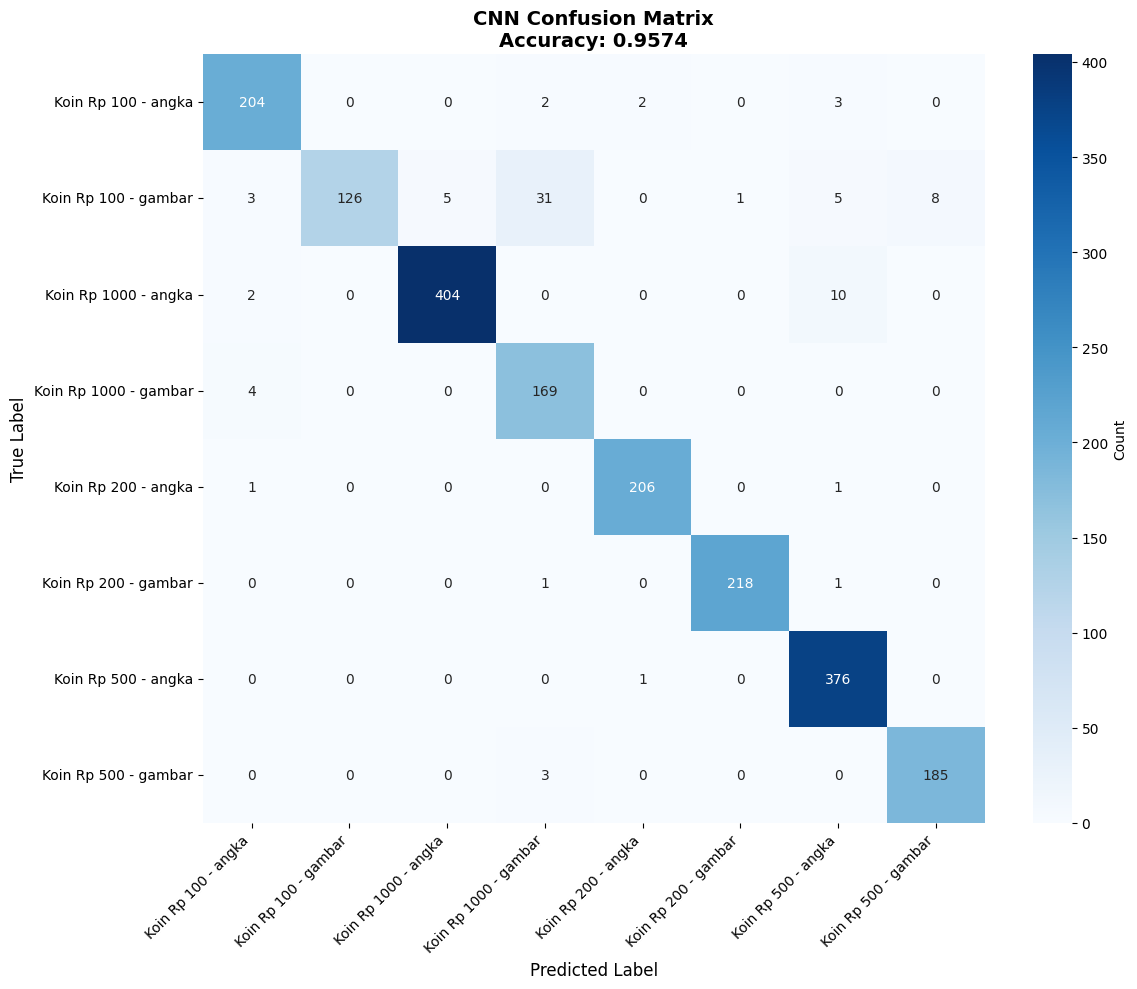

In [15]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            ax=ax, cbar_kws={'label': 'Count'})

ax.set_title(f'CNN Confusion Matrix\nAccuracy: {test_accuracy:.4f}', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'confusion_matrix' / 'cnn_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 16. Per-Class Performance Analysis

In [16]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred, labels=range(len(class_names)), zero_division=0
)

per_class_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("="*70)
print("PER-CLASS PERFORMANCE")
print("="*70)
print(per_class_df.to_string(index=False))
print("="*70)

# Save per-class performance
per_class_df.to_csv(RESULTS_DIR / 'per_class_performance.csv', index=False)
print(f"\nSaved to: {RESULTS_DIR / 'per_class_performance.csv'}")

PER-CLASS PERFORMANCE
                Class  Precision   Recall  F1-Score  Support
  Koin Rp 100 - angka   0.953271 0.966825  0.960000      211
 Koin Rp 100 - gambar   1.000000 0.703911  0.826230      179
 Koin Rp 1000 - angka   0.987775 0.971154  0.979394      416
Koin Rp 1000 - gambar   0.820388 0.976879  0.891821      173
  Koin Rp 200 - angka   0.985646 0.990385  0.988010      208
 Koin Rp 200 - gambar   0.995434 0.990909  0.993166      220
  Koin Rp 500 - angka   0.949495 0.997347  0.972833      377
 Koin Rp 500 - gambar   0.958549 0.984043  0.971129      188

Saved to: D:\dev\semester5\pengolahan-citra\projek-edge-detection\results\coin_classification_cnn\per_class_performance.csv


### 16.1 Visualisasi F1-Score per Class

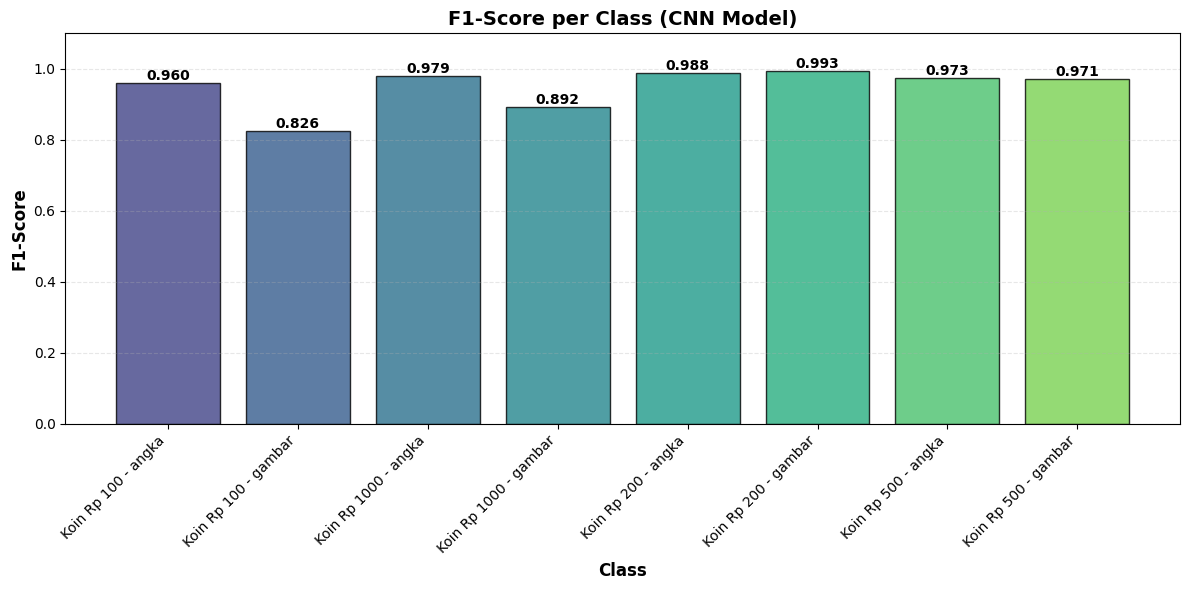

In [17]:
# Plot F1-Score per class
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(class_names)))
bars = ax.bar(range(len(class_names)), per_class_df['F1-Score'], color=colors, alpha=0.8, edgecolor='black')

# Add value labels on bars
for bar, f1_val in zip(bars, per_class_df['F1-Score']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{f1_val:.3f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('F1-Score per Class (CNN Model)', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'visualizations' / 'f1_score_per_class.png', dpi=150, bbox_inches='tight')
plt.show()

## 17. Analisis Kesalahan Prediksi

In [18]:
misclassified_indices = np.where(y_test != y_pred)[0]
correct_indices = np.where(y_test == y_pred)[0]

print(f"Total test samples: {len(y_test)}")
print(f"Correct: {len(correct_indices)} ({len(correct_indices)/len(y_test)*100:.2f}%)")
print(f"Misclassified: {len(misclassified_indices)} ({len(misclassified_indices)/len(y_test)*100:.2f}%)")

print("\nBreakdown per kelas:")
for cls_idx, cls_name in enumerate(class_names):
    class_mask = y_test == cls_idx
    class_total = np.sum(class_mask)
    class_misclassified = np.sum((y_test == cls_idx) & (y_pred != cls_idx))
    
    print(f"  {cls_name}: {class_total} total, {class_misclassified} misclassified ({class_misclassified/class_total*100:.2f}%)")
    
    if class_misclassified > 0:
        misclass_mask = (y_test == cls_idx) & (y_pred != cls_idx)
        predicted_as = y_pred[misclass_mask]
        for pred_idx in range(len(class_names)):
            pred_count = np.sum(predicted_as == pred_idx)
            if pred_count > 0:
                print(f"      → {pred_count}x as {class_names[pred_idx]}")

Total test samples: 1972
Correct: 1888 (95.74%)
Misclassified: 84 (4.26%)

Breakdown per kelas:
  Koin Rp 100 - angka: 211 total, 7 misclassified (3.32%)
      → 2x as Koin Rp 1000 - gambar
      → 2x as Koin Rp 200 - angka
      → 3x as Koin Rp 500 - angka
  Koin Rp 100 - gambar: 179 total, 53 misclassified (29.61%)
      → 3x as Koin Rp 100 - angka
      → 5x as Koin Rp 1000 - angka
      → 31x as Koin Rp 1000 - gambar
      → 1x as Koin Rp 200 - gambar
      → 5x as Koin Rp 500 - angka
      → 8x as Koin Rp 500 - gambar
  Koin Rp 1000 - angka: 416 total, 12 misclassified (2.88%)
      → 2x as Koin Rp 100 - angka
      → 10x as Koin Rp 500 - angka
  Koin Rp 1000 - gambar: 173 total, 4 misclassified (2.31%)
      → 4x as Koin Rp 100 - angka
  Koin Rp 200 - angka: 208 total, 2 misclassified (0.96%)
      → 1x as Koin Rp 100 - angka
      → 1x as Koin Rp 500 - angka
  Koin Rp 200 - gambar: 220 total, 2 misclassified (0.91%)
      → 1x as Koin Rp 1000 - gambar
      → 1x as Koin Rp 500 -

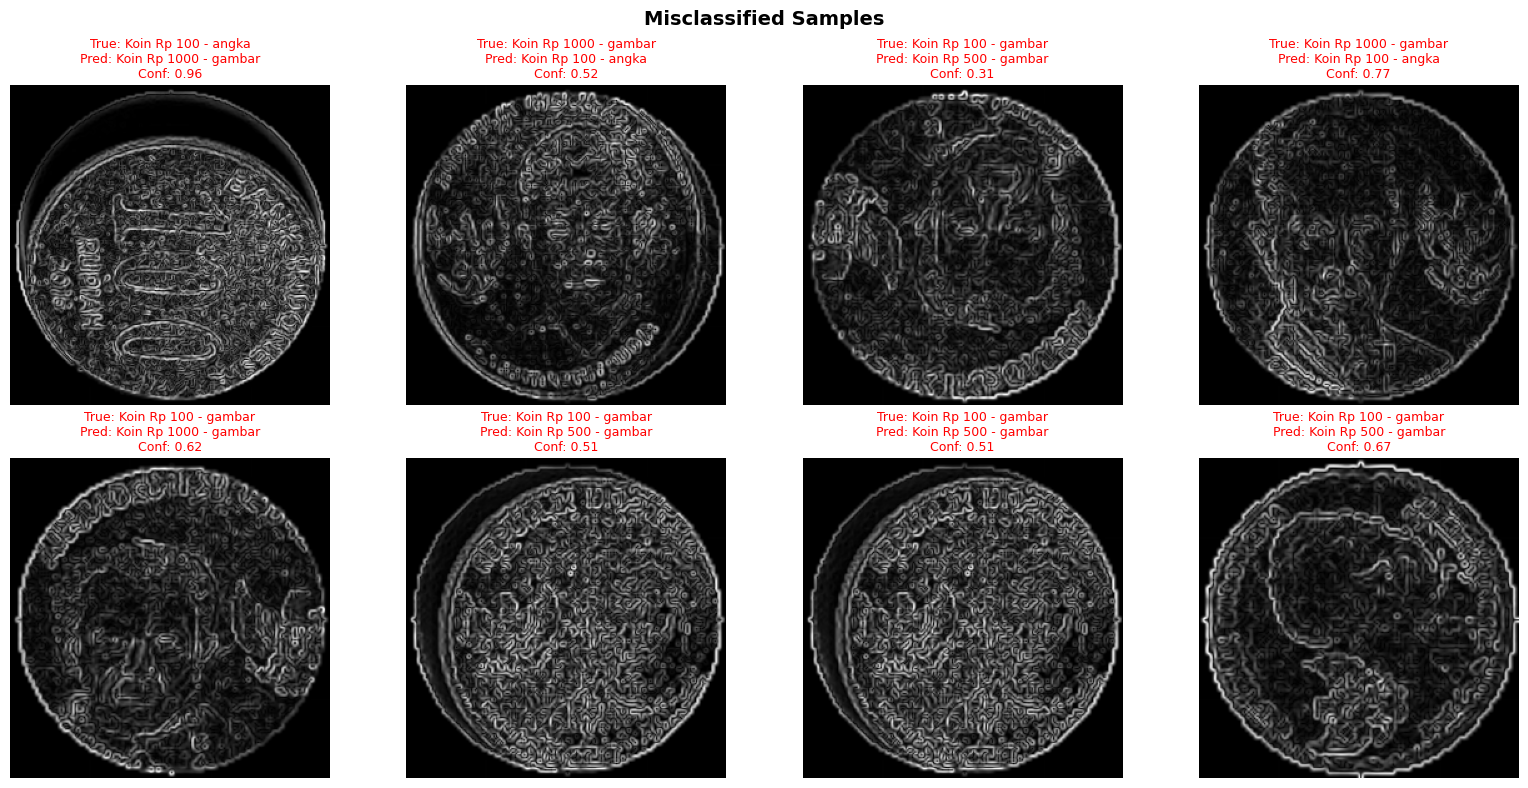

In [19]:
# Visualize some misclassified samples
if len(misclassified_indices) > 0:
    num_to_show = min(8, len(misclassified_indices))
    sample_indices = np.random.choice(misclassified_indices, num_to_show, replace=False)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for idx, sample_idx in enumerate(sample_indices):
        img = X_test[sample_idx].squeeze()  # Remove channel dimension
        true_label = y_test[sample_idx]
        pred_label = y_pred[sample_idx]
        confidence = y_pred_proba[sample_idx][pred_label]
        
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {confidence:.2f}',
                          fontsize=9, color='red')
        axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(num_to_show, 8):
        axes[idx].axis('off')
    
    plt.suptitle('Misclassified Samples', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'visualizations' / 'misclassified_samples.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No misclassified samples!")

In [20]:
from collections import defaultdict

confusion_pairs = defaultdict(int)

for idx in misclassified_indices:
    true_label = y_test[idx]
    pred_label = y_pred[idx]
    pair = f"{class_names[true_label]} → {class_names[pred_label]}"
    confusion_pairs[pair] += 1

print("Top confusion pairs:")
sorted_pairs = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)
for pair, count in sorted_pairs[:10]:
    print(f"  {pair}: {count}x")

Top confusion pairs:
  Koin Rp 100 - gambar → Koin Rp 1000 - gambar: 31x
  Koin Rp 1000 - angka → Koin Rp 500 - angka: 10x
  Koin Rp 100 - gambar → Koin Rp 500 - gambar: 8x
  Koin Rp 100 - gambar → Koin Rp 1000 - angka: 5x
  Koin Rp 100 - gambar → Koin Rp 500 - angka: 5x
  Koin Rp 1000 - gambar → Koin Rp 100 - angka: 4x
  Koin Rp 100 - gambar → Koin Rp 100 - angka: 3x
  Koin Rp 500 - gambar → Koin Rp 1000 - gambar: 3x
  Koin Rp 100 - angka → Koin Rp 500 - angka: 3x
  Koin Rp 100 - angka → Koin Rp 200 - angka: 2x


## 18. Save CNN Model

In [21]:
import pickle

MODELS_DIR = BASE_DIR / 'models'
MODELS_DIR.mkdir(exist_ok=True)

# Save CNN model in Keras format
model_name = 'coin_classifier_cnn_8class'
model_path = MODELS_DIR / f'{model_name}.keras'
model.save(model_path)

print(f"CNN Model saved: {model_path.relative_to(BASE_DIR)}")

# Save class names for inference
class_names_path = MODELS_DIR / f'{model_name}_classes.pkl'
with open(class_names_path, 'wb') as f:
    pickle.dump(class_names, f)

print(f"Classes saved: {class_names_path.relative_to(BASE_DIR)}")

# Save training configuration
config = {
    'image_size': IMAGE_SIZE,
    'edge_method': 'sobel',
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE,
    'num_classes': len(class_names),
    'final_accuracy': test_accuracy
}

config_path = MODELS_DIR / f'{model_name}_config.pkl'
with open(config_path, 'wb') as f:
    pickle.dump(config, f)

print(f"Config saved: {config_path.relative_to(BASE_DIR)}")

print(f"\n" + "="*70)
print("MODEL SUMMARY")
print("="*70)
print(f"Model: CNN (Convolutional Neural Network)")
print(f"Input: {IMAGE_SIZE[0]}x{IMAGE_SIZE[1]} grayscale edge images")
print(f"Epochs: {EPOCHS}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"\nClasses ({len(class_names)}):")
for i, name in enumerate(class_names):
    print(f"  {i}: {name}")
print("="*70)

CNN Model saved: models\coin_classifier_cnn_8class.keras
Classes saved: models\coin_classifier_cnn_8class_classes.pkl
Config saved: models\coin_classifier_cnn_8class_config.pkl

MODEL SUMMARY
Model: CNN (Convolutional Neural Network)
Input: 256x256 grayscale edge images
Epochs: 5
Test Accuracy: 0.9574 (95.74%)

Classes (8):
  0: Koin Rp 100 - angka
  1: Koin Rp 100 - gambar
  2: Koin Rp 1000 - angka
  3: Koin Rp 1000 - gambar
  4: Koin Rp 200 - angka
  5: Koin Rp 200 - gambar
  6: Koin Rp 500 - angka
  7: Koin Rp 500 - gambar
